In [ ]:
import keras
keras.__version__

'2.4.3'

## Class Activation Mapping (CAM)

Class Activation Mapping é um processo desenvolvido por [] que consiste em identificar as regiões que mais são relevantes em uma imagem para que a Rede Neural Convolucional a classifique como determinada classe.

O trabalho desenvolvido por Zhou et al se consistiu em utilizar Global Average Pooling para calcular a média espacial de cada feature map, com isso

### Global Average Pooling

Global Average Pooling (GAP) é uma técnica que substitui a necessidade de camadas densas no fim de uma Rede Neural Convolucional, é calculada a média de cada feature map da última camada convolucional e a coloca como entrada diretamente na camada de ativação softmax. 

Algumas vantagens surgem por conta desse método, como a diminuição de overfitting e robustês a translações de imagens na entrada. Apesar dessas questões, o principal motivo da escolha do GAP para [] é a percepção de que vários trabalhos anteriores estavam se preocupando em visualizar apenas as camadas convolucionais das redes neurais [] [] [], ignorando as camadas densas.

Percebendo que a perda de performance ao se utilizar o GAP em detrimento de camadas convolucionais era pouco significativa, Zhou fundamenta o Class Activation Mapping com o GAP, permitindo assim que se visualize completamente suas redes neurais, entendendo-as portanto, do início ao fim.


### Calculo do CAM

Sendo $f_k(x,y)$ a ativação do mapa $k$ da última camada convolucional de uma rede neural para uma imagem $I$, o resultado do GAP é $F_k = \frac{1}{Z} \sum _{x, y} f_k(x,y)$

Sendo $w_k^c$ o peso da classe $c$ classificada para o mapa $k$, a entrada $S_c$ do softmax é $S_c = \sum _k w_k^c F_k$. Portanto esse termo $w_k^c$ mostra a importância do mapa $k$ para essa classificação da imagem. Sendo assim, define-se o mapa de ativação de classes (CAM) pela seguinte fórmula:

$$M_c (x,y) = \sum_k w_k^c f_k(x,y)$$


Cada $f_k$ é um mapa que representa um padrão visual que colabora para a ativação de $S_c$. Então CAM é simplesmente uma combinação linear ponderada por $w_k^c$ desses padrões visuais. Portanto, $M_c (x,y)$ indica a importância do pixel $(x,y)$ para a classificação $c$ para a imagem $I$. 

Um exemplo do cálculo de $M_c(x,y)$ para um exemplo real está na imagem a seguir:


<img src='https://drive.google.com/uc?id=1dBnUFj-TClvCubtXNkOwjkCYAVXo9CA4'>



## Grad CAM

### Motivação

A principal limitação do método de Class Activation Mapping é o fato de que ele só pode ser calculado para Redes Convolucionais com uma arquitetura específica, a saber, os feature maps devem preceder diretamente a camada final de classificação.

Para aplicar o CAM em Redes que não seguem essa estrutura, a opção é modificar a arquitetura. Por exemplo para casos de CNNs que possuem camadas densas após as camadas convolucionais, a solução é substituí-las por camadas convolucionais convencionais, e após isso treiná-las novamente.

A despeito dessa solução permitir a aplicação desse métdo em diversas Redes Neurais diferentes, ela carrega consigo limitações. Além dessa modificação na arquitetura frequentemente diminuir a acurácia das CNNs para tarefas simples (como classificação de imagens), existem problemas que essa arquitetura não é capaz de resolver().

Portanto, surge a necessidade de generalizar a ideia do CAM para que ela seja possível de ser aplicada para qualquer Rede Neural Convolucional, independente de sua arquitetura, e é dessa necessidade que surge o Grad-CAM.

### Abordagem

Para o caso de uma arquitetura qualquer de CNN, a "relevância" de cada feature map é calculada com o gradiente da saída $y^c$ com respeito a cada feature map.
Definimos $\alpha _k^c$ como o GAP desse gradiente, ou seja:

$$ \alpha _k^c = \sum _{x,y} \frac{\partial S_c}{\partial f_k(x,y)} $$

Portanto, de modo semelhante ao CAM, o grad-CAM é uma combinação linear ponderada dos feature maps, com a diferença de que é seguida por um ReLU:

$$ M_c(x,y) = ReLU \left(\sum _k \alpha _k^c f_k(x,y)\right) $$

Portanto, com esse método chegamos a um mapa de calor da mesma natureza do gerado pelo CAM, com a diferença que este pode ser calculado para CNNs de arquiteturas diversas.


In [ ]:
!pip install tf-keras-vis tensorflow

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
from keras.models import load_model

model = load_model('intel_images.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 50)        4

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir $HOME/.kaggle
!mv kaggle.json $HOME/.kaggle/kaggle.json
!chmod 600 $HOME/.kaggle/kaggle.jso


!kaggle datasets download -d puneet6060/intel-image-classification

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes
chmod: cannot access '/root/.kaggle/kaggle.jso': No such file or directory
 99% 343M/346M [00:02<00:00, 208MB/s]
100% 346M/346M [00:02<00:00, 175MB/s]


In [ ]:
!unzip -qq /content/intel-image-classification.zip -d /datalab/ 

In [ ]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [ ]:
def prever(modelo, imagens):
  ind = []
  previsao = modelo.predict(imagens)
  for i in range (len(imagens)):
    ind.append(np.argmax(previsao[i]))
  res = []
  for i in range (len(imagens)):
    if ind[i] == 0:
      res.append("Construcoes")
    if ind[i] == 1:
      res.append("Floresta")
    if ind[i] == 2:
      res.append("Glacial")
    if ind[i] == 3:
      res.append("Montanhas")
    if ind[i] == 4:
      res.append("Mar")
    if ind[i] == 5:
      res.append("Ruas")
    
  return res, ind

In [ ]:
import os
import cv2
from sklearn.utils import shuffle

Images, Labels = get_images('/datalab/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

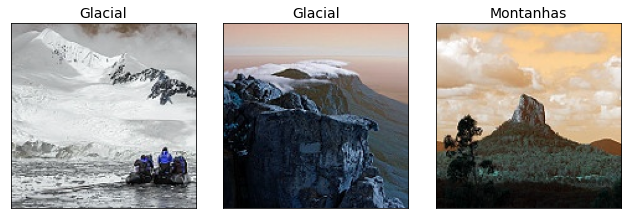

In [ ]:
from tensorflow.keras.preprocessing.image import load_img




img = Images[207:210]

image_titles, indices = prever(model,img)


subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(img[i])
plt.tight_layout()
plt.show()

In [ ]:

def loss(output):
    return (output[0][indices[0]], output[1][indices[1]], output[2][indices[2]])

In [ ]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

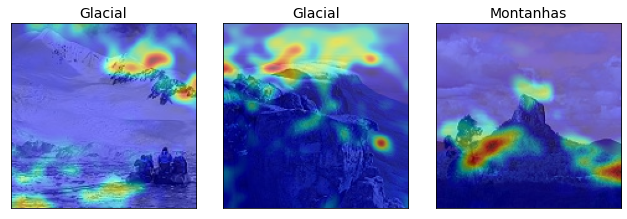

In [ ]:
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

imagem = tf.cast(img, tf.float32)

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              imagem,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(img[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

## 5.Bibliografia

[1] https://arxiv.org/abs/1512.04150

[2] https://arxiv.org/abs/1610.02391

[3] https://pypi.org/project/tf-keras-vis/

[4] https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

[5] https://www.kaggle.com/c/dogs-vs-cats

[6] https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

[7] https://github.com/fchollet/deep-learning-with-python-notebooks